<a href="https://colab.research.google.com/github/TAUforPython/stohasticsignal/blob/main/%D1%81%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

Text(0, 0.5, 'y (экспериментальные измерения)')

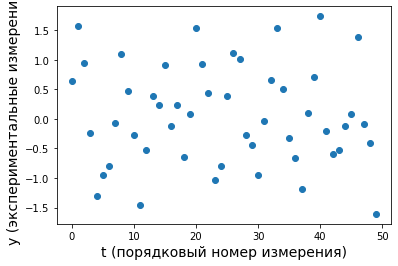

In [15]:
def dataset_stohastic(mu, noise_sigma, data_size, random_state):
    t = np.arange(0, data_size, 1.)
    random.seed(random_state)
    noise = np.empty((data_size, 1))
    y = np.empty((data_size))

    for i in range(data_size):
        noise[i] = random.gauss(mu, noise_sigma)
        y[i] = np.sin(t[i]) + noise[i]

    return t, y

data_size = 50 # размер генерируемого набора данных
noise_sigma = 0.5 # СКО шума в данных
mu = 0 # математическое ожидание
t, y = dataset_stohastic(mu, noise_sigma, data_size, 1)

plt.plot(t, y, 'o') 
plt.xlabel('t (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (экспериментальные измерения)', fontsize=14)

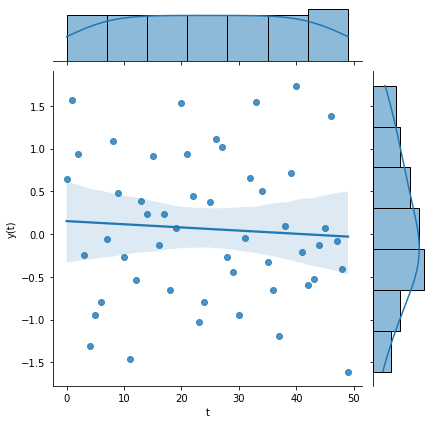

In [16]:
# создаем датафрейм для красивого изображения данных 
# сигнал случайный, формируем одну выборку

d = {'y(t)': y, 't': t}
df = pd.DataFrame(d)
seaborn.jointplot(data=df, x = "t", y = "y(t)",kind='reg')

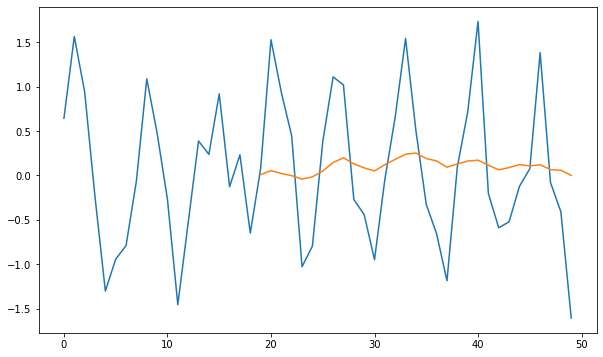

In [17]:
# расчет скользящего среднего
df['y(t)'].plot(figsize=(10,6))
df['y(t)'].rolling(window = 20).mean().plot()
y_mean = df['y(t)'].rolling(window = 20).mean()

         t         y
0      0.0  0.470858
1      1.0  0.143182
2      2.0  0.569440
3      3.0  0.326372
4      4.0 -1.264977
...    ...       ...
1495  45.0  1.063230
1496  46.0  0.273412
1497  47.0  0.494722
1498  48.0 -1.912562
1499  49.0 -0.709930

[1500 rows x 2 columns]


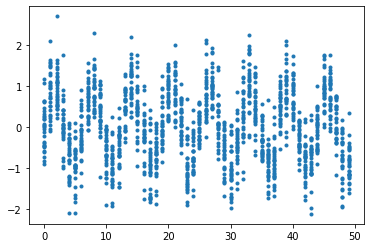

In [18]:
data_size = 50 # размер генерируемого набора данных
noise_sigma = 0.5 # СКО шума в данных
mu = 0 # математическое ожидание
x_cortege = []
y_cortege = []
for i in range(30):
     x_t, y_t = dataset_stohastic(mu, noise_sigma, data_size, i)
     x_cortege = np.append(x_cortege, x_t)
     y_cortege = np.append(y_cortege, y_t)
plt.plot(x_cortege,y_cortege,'.')
dataframe_cortege = {
    "t": x_cortege,
    "y": y_cortege
}
df = pd.DataFrame(dataframe_cortege)

print(df)

<Axes: xlabel='t', ylabel='y'>

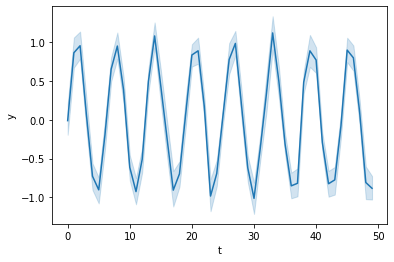

In [19]:
seaborn.lineplot(x = "t", y= "y", data = df, markers = True)

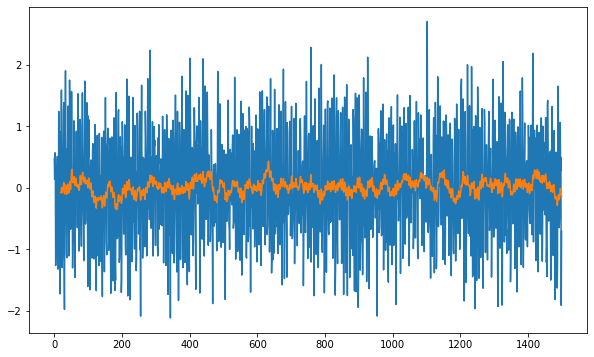

In [20]:
df['y'].plot(figsize=(10,6))
df['y'].rolling(window = 20).mean().plot()
y_mean = df['y'].rolling(window = 20).mean()

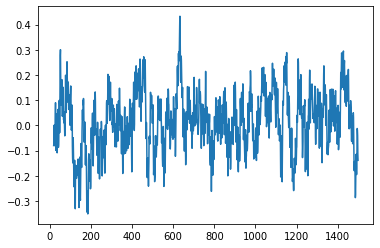

In [21]:
plt.plot(y_mean)